<a href="https://colab.research.google.com/github/LadyLandshark/Annoyatron/blob/master/khill9_cs480e_2023%2C3f_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS480E/580E: Final Exam





## General Instructions
### Due December 13th, 11:59 PM.

In the final exam, you will use autoencoders to do dimensionality reduction on the MNIST images. You will then use the reduced dimensional representations to perform similarity search on test images. At the end of notebook, you will be able to retrieve k-most similar images on the training set.  


Functions and cells that need to be implemented are marked with a bold **implement** keyword or clearly marked in the experiments section.

Make sure to **run** the cells marked for running to make sure all the data and functions are available.


In [1]:
import math
import random
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.datasets as dset
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

%matplotlib inline


# for plotting
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['font.size'] = 16
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Dataset

You will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9).

To simplify our code here, use the PyTorch MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST_data`.

**Run** the following cell to mount your drive on colab.

In [2]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Run** the following cells to retrieve the MNIST training, validation, and test sets

In [3]:
mnist_train = dset.MNIST('./MNIST_data', train=True, download=True,
                           transform=T.ToTensor())

mnist_test = dset.MNIST('./MNIST_data', train=False, download=True,
                        transform=T.ToTensor())

mnist_train, mnist_validation = random_split(mnist_train, [.8, .2])

100%|██████████| 9912422/9912422 [00:00<00:00, 83691399.40it/s]


Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 56211458.85it/s]

Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 31281877.83it/s]


Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4841303.37it/s]


Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



**Run** this cell to print the number of cells on the traning, validation, and test datasets.

In [4]:
print(len(mnist_train), len(mnist_validation), len(mnist_test))

48000 12000 10000


**Run** this cell to define the helper function to generate grids of images.

In [5]:
def show_images(images):
    images = torch.reshape(
        images, [images.shape[0], -1]
    )  # images reshape to (batch_size, D)
    sqrtn = int(math.ceil(math.sqrt(images.shape[0])))
    sqrtimg = int(math.ceil(math.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis("off")
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect("equal")
        plt.imshow(img.reshape([sqrtimg, sqrtimg]))
    return

**Implement** the following cell to define a `batch_size`, `loader_train`, and `loader_validation`.

`batch_size` should be an integer value that defines the number of samples per mini-batch that will be used for the training dataloader.

`loader_train` should be a PyTorch DataLoader on the `mnist_train` dataset with `batch_size = batch_size`, `shuffle` enabled and drop the last mini-batch.

`loader_validation` should be a PyTorch DataLoader on the `mnist_validation` dataset. Set the `batch_size` as high as possible for this.

In [6]:
# ==== BEGIN SOLUTION CODE ====
batch_size = 128
loader_train = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
loader_validation = DataLoader(mnist_validation, batch_size=len(mnist_validation))
# ==== END SOLUTION CODE ====

**Run** the following cell to show an example of a grid of MNIST images.

28.0


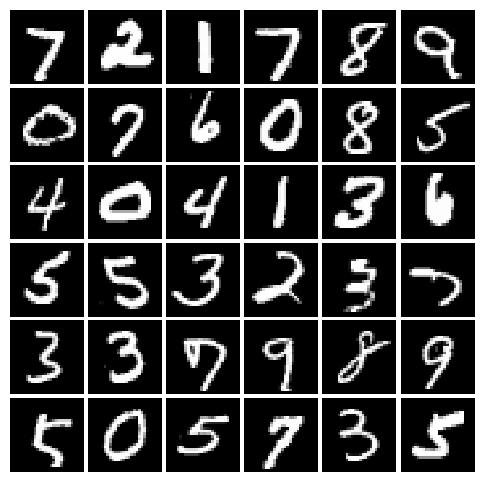

In [7]:
imgs = next(iter(loader_train))[0].view(batch_size, 784)
show_images(imgs[:36])
print(np.sqrt(784))

# (Part 1) Autoencoder - 60 pts

In the next cell, **implement** the definition of the `AutoEncoder` class, that implements an autoencoder using convolutions, transpose convolutions, fully connected and non-linear activation layers.



You are free to choose any architecture you would like.
**But your network must use at least 1 convolution layer**


Complete the following methods:

- `__init__(height, width, latent_dim)`: Initializes the desired layer and architecture.
  - The inputs to the class constructor are:
    - `height`: The height of the input images
    - `width`: The width of the input images
    - `latent_dim`: The size of the latent vector
- `encode(x)`: Encodes a batch of images `x` to a batch of latent vectors, `h`
- `decode(h)`: Decodes a batch of latent vectors `h` to a batch images, `x_reconstructed`
- `forward(x)`: Uses `encode` and `decode` method to compress and reconstruct a batch of images, `x`.

In [38]:
class AutoEncoder(nn.Module):
    def __init__(self, height, width, latent_dim):
        """
        """
        super().__init__()

        # ==== BEGIN SOLUTION CODE ====
        self.height = height
        self.width = width
        self.latent_dim = latent_dim
        self.layer_map = {
            'conv1' : nn.Conv2d(1, 8, 3),
            'relu1' : nn.ReLU(),
            'pool1' : nn.MaxPool2d(2, return_indices=True),
            'conv2' : nn.Conv2d(8, 16, 3),
            'relu2' : nn.ReLU(),
            'pool2' : nn.MaxPool2d(2, return_indices=True),
            'flatten': nn.Flatten(),
            'linear': nn.Linear(400, self.latent_dim),
            'relu_final': nn.ReLU()
        }
        self.decode_layers = [
            nn.Linear(self.latent_dim, 400),
            nn.Unflatten(1, (16, 5, 5)),
            nn.MaxUnpool2d(2),
            nn.ConvTranspose2d(16, 8, 3),
            nn.ReLU(),
            nn.MaxUnpool2d(2),
            nn.ConvTranspose2d(8, 1, 3),
            nn.ReLU(),
            nn.Sigmoid()
        ]
        self.layers = nn.ModuleList(list(self.layer_map.values()) + self.decode_layers)
        #self.parameters = nn.ParameterList([self.height, self.width, self.latent_dim])



        # ==== END SOLUTION CODE ====
    def encode(self, x):
        """
        """
        h = None
        # ==== BEGIN SOLUTION CODE ====
        #print(f'X shape: {x.shape}')
        conv1 = self.layer_map['conv1'](x)
        relu1 = self.layer_map['relu1'](conv1)
        #print(f"Relu1 shape: {relu1.shape}")
        (pool1, self.indices1) = self.layer_map['pool1'](relu1)
        self.outsize1 = relu1.size()
        relu2 = self.layer_map['relu2'](pool1)
        conv2 = self.layer_map['conv2'](relu2)
        (pool2, self.indices2) = self.layer_map['pool2'](conv2)
        self.outsize2 = conv2.size()
        flattened = self.layer_map['flatten'](pool2)
        linear = self.layer_map['linear'](flattened)
        h = self.layer_map['relu_final'](linear)

        # ==== END SOLUTION CODE ====
        return h

    def decode(self, h):
        """
        """
        x_reconstructed = None
        # ==== BEGIN SOLUTION CODE ====
        data_shape = h.shape
        #print(f"H shape: {h.shape}")
        #reshaped = torch.reshape(h, (self.height, self.width))


        curr_out = h
        for i, layer in enumerate(self.decode_layers):
          if i == 2:
            #print(f"{curr_out.shape}, {self.indices2.shape}")
            curr_out = layer(curr_out, self.indices2, self.outsize2)
          elif i == 5:
            curr_out = layer(curr_out, self.indices1, self.outsize1)
          else:
            curr_out = layer(curr_out)

        x_reconstructed = curr_out
        # ==== END SOLUTION CODE ====
        return x_reconstructed

    def forward(self, x):
        """
        """
        x_reconstructed = None
        # ==== BEGIN SOLUTION CODE ====
        encoded = self.encode(x)
        x_reconstructed = self.decode(encoded)
        # ==== END SOLUTION CODE ====
        return x_reconstructed

## Autoencoder Training

In the following cell, define an autoencoder (AE) and train on the training set.

The AE training algorithm is as follows:

1. Instantiate an `AutoEncoder`
2. Define an optimizer for your AE
3. For each batch of data in `loader_train`:
    - Pass the input through the AE to get the reconstructed input
    - Calculate the loss using the [`nn.functional.binary_cross_entropy`](https://pytorch.org/docs/stable/generated/torch.nn.functional.binary_cross_entropy.html)
    - Zero the gradients, propagate the loss backwards, and update the  weights using the optimizer

4. Repeat 3
5. After N iterations (or every epoch), compute the validation loss over the validation set (using the `loader_validation`).


In [ ]:
model = AutoEncoder(28,28,784) # Instantiate your model to this variable

# ==== BEGIN SOLUTION CODE ====
learning_rate = 0.1
epochs = 3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
for epoch in range(epochs):
  # train
  model.train()
  for batch, (x, y) in enumerate(loader_train, 0):
    optimizer.zero_grad()
    reconstructed = model.forward(x)
    if torch.max(reconstructed) > 1:
      print(reconstructed)
    loss = nn.functional.binary_cross_entropy(reconstructed, x)
    #print('bob')
    loss.backward()
    optimizer.step()

  # test
  model.eval()
  size = len(loader_validation.dataset)
  num_batches = len(loader_validation)
  validation_loss = 0
  for batch, (x, y) in enumerate(loader_validation):
    reconstructed = model.forward(x)
    loss = nn.functional.binary_cross_entropy(reconstructed, x)
    validation_loss += loss.item()
  validation_loss /= num_batches
  print(f"Validation Loss  = {validation_loss}")
#  scheduler.step()



# ==== END SOLUTION CODE ====

Validation Loss  = 0.6931470036506653


**Implement** the following cell to generate 36 random reconstructions from your previously trained AE model and visualize the outputs.

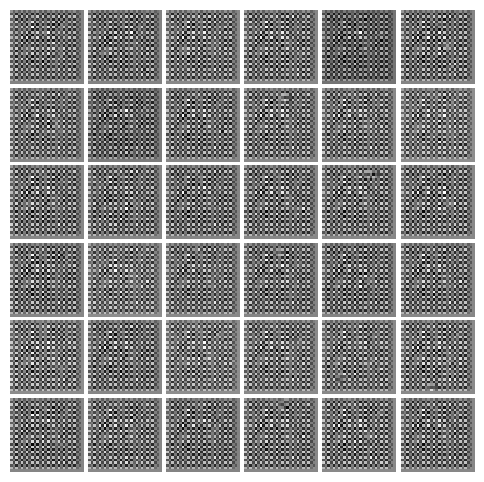

In [29]:
# ==== BEGIN SOLUTION CODE ====
with torch.no_grad():
  batch = next(iter(loader_train))
  reconstructed = model.forward(batch[0])
  images = reconstructed.view(batch_size, 784)
  show_images(images[:36])


# ==== END SOLUTION CODE ====

# (Part 2, 40 pts Extra Credit) Similarity Search

Now using your trained model, you will generate latent vectors of the training images. This will encode the images into a vector.

You will also use your trained models to encode a test image into a vector, compute a similarity measure ($L_2$ or Cosine-similarity) with the training latent vectors.

**Implement** the following cell to complete the `generate_latent_vectors` function.

The arguments are:

- `model`: The model used to generate the latent encodings
- `dataset`: The dataset to the generate the latent encodings

Returns:
- PyTorch tensor of latent vectors computed from the dataset images using the model. It should be a 2D tensor with `len(dataset)` rows and `latent_dim` columns.

Iterate over each image in the `dataset` and `encode` the images using the `model`. Make sure to turn off backprop and gradient calculations using `with torch.no_grad()` and set the model to evaluation mode using `model.eval()`.

You may find the `torch.vstack` function useful.

In [ ]:
def generate_latent_vectors(model, dataset):
    '''
    Iterates over the dataset and uses the model to generates latent vectors.
    Returns a Torch tensor of latent vectors of shape

    Args:
      - model : trained model
      - dataset: PyTorch dataset of images

    Returns:
      - latent_vectors - Torch tensor of dimension (len(dataset), latent_dim).
    '''
    latent_vectors = None
    # ==== BEGIN SOLUTION CODE ====

    # ==== END SOLUTION CODE ====
    return latent_vectors

**Run** the following cell to generate the latent vectors of the images from the `mnist_train` dataset using your `model` and the `generate_latent_vectors` dataset.

In [ ]:
training_vectors = generate_latent_vectors(model, mnist_train)

**Implement** the `cosine_sim` function that computes the cosine similarity between each row of input tensors `a` and `b` and the 1-D tensor of indices with the of the `k` closest values.


*Hint: You can use the [torch.nn.functional.cosine_similarity](https://pytorch.org/docs/stable/generated/torch.nn.functional.cosine_similarity.html#torch.nn.functional.cosine_similarity) and
[torch.topk](https://pytorch.org/docs/stable/generated/torch.topk.html) functions. Make sure you use the appropriate parameters*  

In [ ]:
def cosine_sim(a, b, k=5):
    # ==== BEGIN SOLUTION CODE ====

    # ==== END SOLUTION CODE ====

**Implement** the `l2_pairwise_dist` function that computes the l2 distance between each row of input tensors `a` and `b` and returns the 1-D tensor of indices with the of the `k` closest values.

*Hint: You can use the [torch.nn.functional.pairwise_distance](https://pytorch.org/docs/stable/generated/torch.nn.functional.pairwise_distance.html#torch.nn.functional.pairwise_distance) and
[torch.topk](https://pytorch.org/docs/stable/generated/torch.topk.html) functions. Make sure you use the appropriate parameters*

In [ ]:
def l2_pairwise_dist(a, b, k=5):
    # ==== BEGIN SOLUTION CODE ====

    # ==== END SOLUTION CODE ====

**Implement** the following function to find the top-k most similar images for a given image using a given 2-D array of latent vectors.

The arguments are:
  - `img`: The image to search similar images for.
  - `model`: The trained model to use to generate latent vector of `img`.
  - `latents`: The 2D tensor of latent vectors of the training dataset. Find the similar vectors to `img`s latent vector within this 2D tensor.
  - `k`: The number of indices to return (default: 5)
  - `distance_function`: The distance function to use to measure the similarity between latent vectors.  
  

Returns:
    - The 1-D tensor of indices of the similar images to `img`


Get the latent vector of `img` using your `model`s `encode` and then use the `distance_function` to get the `k`-nearest vectors.

In [ ]:
def find_top_k(img, model, latents, k = 5, distance_function=cosine_sim):
    ind = None
    # ==== BEGIN SOLUTION CODE ====

    # ==== END SOLUTION CODE ====
    return ind

**Run** the following cell to define the top-k image visualization helper function.

In [ ]:
def show_top_k_images(root_image, images):

    num_images = len(images) + 1
    sqrtimg = int(math.ceil(math.sqrt(28)))

    fig = plt.figure(figsize=(num_images*2.5, num_images*5))
    gs = gridspec.GridSpec(1, num_images)
    gs.update(wspace=0.05, hspace=0.05)
    images = [root_image] + images

    for i, img in enumerate(images):

        ax = plt.subplot(gs[i])
        plt.axis("off")
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect("equal")
        plt.imshow(img.reshape([28, 28]))
        if i == 0:
            ax.set_title("Search Image")
    return

**Run** the following cell to get the 5 most similar images to an image from the test set using a cosine similarity metric.

If all the above cells are completed correctly, there should be no errors, and the found images should look visually similar.

In [ ]:
root_img_ind = 19
root_img = mnist_test[root_img_ind][0]
_inds = find_top_k(root_img, model, training_vectors, k=5, distance_function= cosine_sim)
images = []
for i in _inds:
    images.append(mnist_train[i][0])
show_top_k_images(root_img, images)

**Run** the following cell to get the 5 most similar images to an image from the test set using a $\mathcal{l}_2$ distance.


If all the above cells are completed correctly, there should be no errors, and the found images should look visually similar.

In [ ]:
root_img_ind = 19
root_img = mnist_test[root_img_ind][0]
_inds = find_top_k(root_img, model, training_vectors, k=5, distance_function=l2_pairwise_dist)
images = []
for i in _inds:
    images.append(mnist_train[i][0])
show_top_k_images(root_img, images)